In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io


from PIL import Image
import numpy as np
from pylab import *

# %pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import requests
import random

import cv2

import os
sys.path.append('/s/bach/j/under/mikylab/research/segmentation_dataset2/')

In [3]:
import model

In [4]:
NO_OF_TRAINING_IMAGES = len(os.listdir('/s/bach/j/under/mikylab/research/segmentation_dataset2/train_images/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/s/bach/j/under/mikylab/research/segmentation_dataset2/val_images/val'))

NO_OF_EPOCHS = 5

BATCH_SIZE = 1

weights_path = '/s/bach/j/under/mikylab/research/segmentation_dataset2/'

In [5]:
m = model.unet()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

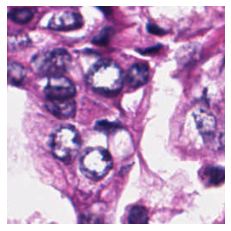

In [6]:
image = load_img('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/test/101.png')
image = img_to_array(image).astype(int)
data = np.expand_dims(image, 0)

mask = load_img('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/101.png')
mask = img_to_array(mask).astype(float)
data_mask = np.expand_dims(mask, 0)

plt.axis('off')
plt.imshow(data[0], cmap= 'gray')

In [7]:
def plot_augmentation(datagen, data, n_rows=1, n_cols=5):
  n_images = n_rows * n_cols
  gen_flow = datagen.flow(data)

  aspect_ratio = data.shape[1] / data.shape[2]
  base_size = 2
  fig_size = (n_cols*base_size/aspect_ratio, n_rows*base_size)
  fig = plt.figure(figsize=fig_size)

  for image_index in range(n_images):
    image = next(gen_flow)
    plt.subplot(n_rows, n_cols, image_index+1)
    plt.axis('off')
    plt.imshow(image[0].astype('uint8'), cmap = "gray", vmin=0, vmax=255)
  fig.tight_layout(pad=0.0)

In [8]:
class CustomDataGenerator(ImageDataGenerator):
    def __init__(self,
               color=None,
               gray=None,
               color_mode = None,
               randomNum = None, 
               **kwargs):
        super().__init__(
            preprocessing_function=self.augmentations,
            **kwargs)

        self.color = color
        self.gray = gray
        self.color_mode = color_mode
    def augmentations(self, image):
        '''Takes an input image and returns a modified version of it'''
        if (self.gray == True and self.color == True):
            randomNum = random.randint(0, 1)
            if (randomNum == 0):
                image = tf.image.rgb_to_grayscale(image, name=None)
                newimage = reshape(image,(256,256))
                newimage = np.stack((newimage,)*3, axis=-1)
        elif(self.gray == True):
            image = tf.image.rgb_to_grayscale(image, name=None)
            newimage = reshape(image,(256,256))
            newimage = np.stack((newimage,)*3, axis=-1)
        #image = np.clip(image, 0, 255) 
        if (self.color_mode == "grayscale"):
            image = tf.image.rgb_to_grayscale(image, name=None)
            
        return image
            

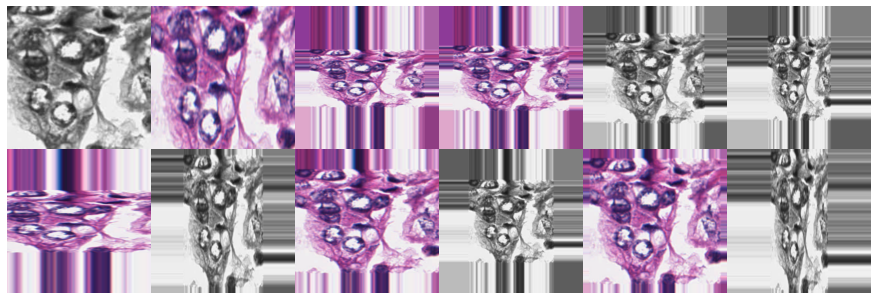

In [132]:
data_gen = CustomDataGenerator(color=True,
                               gray=True,
                              zoom_range=[.5, 2.5])
data_gen.fit(data)
plot_augmentation(data_gen, data, n_rows=2, n_cols=6)

In [10]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)


def threshold_function(img):
    return (img > 0.5).astype("float32")

In [11]:
color_datagen = CustomDataGenerator(color=True,
                               gray=True,
                              dtype=float,
                            rescale=1./255,
                            rotation_range = 90,
                            shear_range=0.2,
                            zoom_range=[.5, 2.5],
                            horizontal_flip=True, 
                            vertical_flip = True,
                            width_shift_range=0.3, fill_mode='wrap')

train_datagen = ImageDataGenerator(rescale=1./255)
        
val_datagen = ImageDataGenerator(rescale=1./255)

mask_datagen = ImageDataGenerator(rescale= 1, 
                                    preprocessing_function = threshold_function)

train_mask_datagen = ImageDataGenerator(rescale= 1, 
                                    preprocessing_function = threshold_function, 
                                    rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[.5, 2.5],
                                    horizontal_flip=True,
                                    vertical_flip = True,
                                    width_shift_range=0.3, fill_mode='wrap')

test_datagen = ImageDataGenerator(rescale=1./255)

seed = 1

In [12]:
image_generator = color_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/train_images/',
    class_mode=None,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    seed=seed)

mask_generator = train_mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/train_masks/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    color_mode = "grayscale",
    seed=seed)


small_image_generator = color_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images_small/',
    class_mode=None,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    seed=seed)
small_mask_generator = train_mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks_small/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    color_mode = "grayscale",
    seed=seed)

val_image_generator = val_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/val_images/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    seed=seed)
val_mask_generator = mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/val_masks/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    color_mode = "grayscale",
    seed=seed)

Found 964 images belonging to 1 classes.
Found 964 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
Found 5 images belonging to 1 classes.
Found 271 images belonging to 1 classes.
Found 271 images belonging to 1 classes.


In [13]:
test_image_generator = test_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    seed=seed)

test_mask_generator = mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    seed=seed, 
    color_mode = "grayscale"
)

grayscale_image_generator = test_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/grayscale_test/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    seed=seed)
grayscale_mask_generator = mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/grayscale_masks/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    seed=seed, 
    color_mode = "grayscale"
)

Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.
Found 136 images belonging to 1 classes.


In [14]:
train_multiphoton_generator = color_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/train_multiphoton/',
    class_mode=None,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    seed=seed)

train_mask_generator = train_mask_datagen.flow_from_directory(
    '/s/bach/j/under/mikylab/research/segmentation_dataset2/train_multiphoton_masks/',
    batch_size = BATCH_SIZE, 
    class_mode=None,
    shuffle = False,
    color_mode = "grayscale",
    seed=seed)

Found 15 images belonging to 1 classes.
Found 15 images belonging to 1 classes.


In [15]:
def combine_generator(gen1, gen2):
    while True:
        yield(next(gen1), next(gen2))

train_generator = combine_generator(image_generator, mask_generator)
train_generator_small = combine_generator(small_image_generator, small_mask_generator)
val_generator = combine_generator(val_image_generator, val_mask_generator)
test_generator = combine_generator(test_image_generator, test_mask_generator)
grayscale_test_generator = combine_generator(grayscale_image_generator, grayscale_mask_generator)
multiphoton_generator = combine_generator(train_multiphoton_generator, train_mask_generator)

full_dataset_generator = combine_generator(train_generator, multiphoton_generator)

In [16]:
def show_img_gen(generator, color):
    for i in range(0,1):
        image = generator[i] 
        if (color == "grayscale"):
            newimage = reshape(image,(256,256))
            plt.imshow(newimage, cmap = 'gray')
            plt.colorbar()
        elif (color == "color"):
            plt.imshow(image)
            plt.colorbar()
        

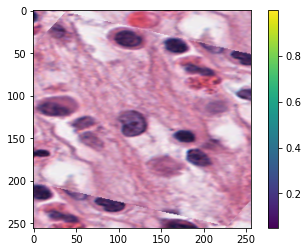

In [124]:
x= image_generator.next()
show_img_gen(x, "color")

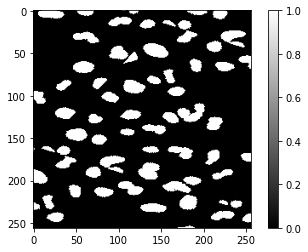

In [125]:
y = mask_generator.next()
show_img_gen(y, "grayscale")

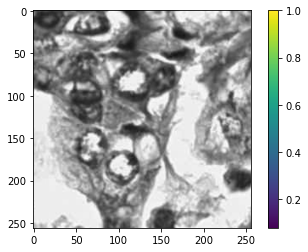

In [19]:
z = grayscale_image_generator.next()
show_img_gen(z, "color")

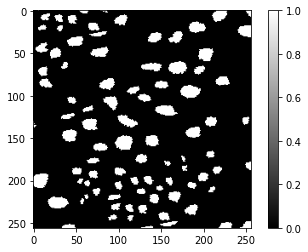

In [20]:
z = train_mask_generator.next()
show_img_gen(z, "grayscale")

In [21]:
def dice_coef(img, img2):
        if img.shape != img2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            
            lenIntersection=0
            
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    if ( np.array_equal(img[i][j],img2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=img.shape[0]*img.shape[1]
            lenimg2=img2.shape[0]*img2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

In [22]:
def show_image_tensor(y_true, y_pred, y_pred_original):
    show_true = y_true.numpy()
    show_pred = y_pred.numpy()
    show_pred2 = y_pred_original.numpy()

    arr_true = show_true[0,:, :]
    new_true = reshape(arr_true,(256,256))
    
    arr_pred = show_pred[0,:, :]
    new_pred = reshape(arr_pred,(256,256))
    
    arr_pred2 = show_pred2[0,:, :]
    new_pred2 = reshape(arr_pred2,(256,256))
    

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
    pos1 = ax1.imshow(new_true, cmap = "gray")
    fig.colorbar(pos1, ax=ax1)
    ax1.set_title('True Mask')
    
    pos2 = ax2.imshow(new_pred, cmap = "gray")
    fig.colorbar(pos2, ax=ax2)
    ax2.set_title('Thresholded Predicted Mask')
    
    pos3 = ax3.imshow(new_pred2, cmap = "gray")
    fig.colorbar(pos3, ax=ax3)
    ax3.set_title('Predicted Mask')

In [154]:
from keras import backend as K

def dice_coef_metric(y_true, y_pred, smooth=1.0):
    y_pred_original = y_pred
    
    y_true = tf.cast(y_true > .5, tf.float32)
    y_pred = tf.cast(y_pred > .5, tf.float32) 

    show_image_tensor(y_true, y_pred, y_pred_original)
      
    intersection = K.sum(y_true * y_pred, axis=(1, 2))
    union = K.sum(y_true, axis=(1, 2)) + K.sum(y_pred, axis = (1, 2))
    score = K.mean( (2. * intersection + smooth) / (union + smooth), axis=0) 
    return score

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dice coef: 0.0


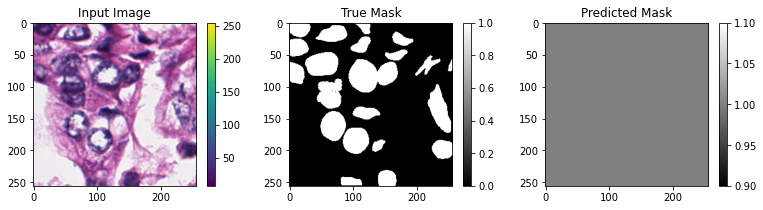

In [24]:
sample_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/test/101.png'))
sample_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/101.png'))

def pred_mask(sample_image, sample_mask, i):
#   sample_image =tf.image.rgb_to_grayscale(sample_image, name=None)
#   plt.imshow(sample_image[...,0], cmap='gray')
#   plt.imshow(sample_image)


    original_image = sample_image#/255.
    
    sample_image = np.expand_dims(sample_image, axis = 0)/255.
    predict_array = m.predict(sample_image) 
    
    arr_pred = predict_array[0,:, :]
    newimage = reshape(arr_pred,(256,256))

    i = i%10
    io.imsave(os.path.join("/s/bach/j/under/mikylab/research/segmentation_dataset2/epoch_checkpoint3.11/","%d_predict_epoch.png"%i),newimage)
    pred = array(Image.open(os.path.join('/s/bach/j/under/mikylab/research/segmentation_dataset2/epoch_checkpoint3.11/', '%d_predict_epoch.png'%i)) ,'f')
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
    pos1 = ax1.imshow(original_image)
    fig.colorbar(pos1, ax=ax1)
    ax1.set_title('Input Image')
    
    pos2 = ax2.imshow(sample_mask >.5, cmap = "gray")
    fig.colorbar(pos2, ax=ax2)
    ax2.set_title('True Mask')
    
    pos3 = ax3.imshow(pred > .5, cmap = "gray")
    fig.colorbar(pos3, ax=ax3)
    ax3.set_title('Predicted Mask')
    
    print("dice coef: " + str(dice_coef(sample_mask, pred)))


pred_mask(sample_image, sample_mask,10)

In [25]:
def dice_score_img(true_mask, pred_mask, pred_mask2):  
    y_true = tf.expand_dims(true_mask, axis=0)
    y_true = tf.dtypes.cast(y_true, tf.float32)
    
    y_pred = tf.expand_dims(pred_mask, axis=0)
    y_pred = tf.dtypes.cast(y_pred, tf.float32)
    
    print(tf.get_static_value(dice_coef_metric(y_true, y_pred, smooth=1)))
    

0.64148337


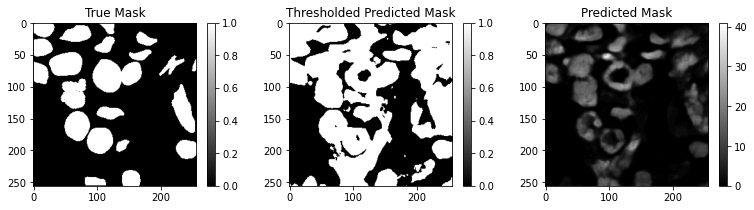

In [148]:
ground_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/101.png'))

pred = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/epoch_checkpoint3.4/10_predict_epoch.png').convert('L'))

dice_score_img(ground_mask, pred, pred)

In [27]:
checkpoint_filepath = '/s/bach/j/under/mikylab/research/segmentation_dataset2/checkpoints3.19/'

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode='min',save_best_only=True)

]

class DisplayCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         pred_mask(sample_image, sample_mask, epoch) 
    
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='loss', mode='min',save_best_only=True)
    
# callbacks = DisplayCallback()
callbacks = my_callbacks

In [100]:
opt = Adam(lr=1E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
steps_epochs = NO_OF_TRAINING_IMAGES/BATCH_SIZE
val_steps = NO_OF_VAL_IMAGES/BATCH_SIZE
m.compile(optimizer = opt, 
          loss = "binary_crossentropy", 
          run_eagerly=True,
          metrics=['accuracy', dice_coef_metric])

In [101]:
# #m.load_weights(checkpoint_filepath)
# dependencies = {
#     'f1_score': f1_score , 'dice_coefficient': dice_coefficient, 'dice_coef_metric': dice_coef_metric
# }
# new_model = tf.keras.models.load_model('/s/bach/j/under/mikylab/research/Model_colorgray_3.3.h5', custom_objects = dependencies)

1/1 [==============================] - 0s 1ms/step - loss: 0.3605 - accuracy: 0.8773 - dice_coef_metric: 0.0573


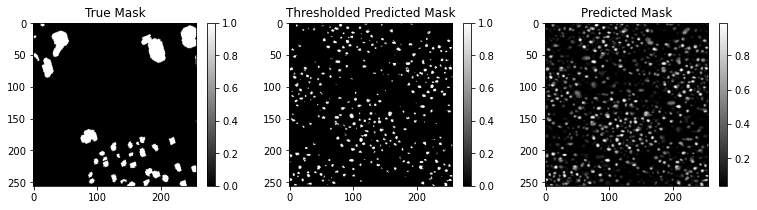

In [105]:
steps_epochs = NO_OF_TRAINING_IMAGES/BATCH_SIZE
val_steps = NO_OF_VAL_IMAGES/BATCH_SIZE


history = m.fit(multiphoton_generator,
                        epochs= 1, 
                        steps_per_epoch = 1,
                        callbacks= [callbacks]) 

In [37]:
m.evaluate(test_generator, steps = 136)

136/136 [==============================] - 2s 13ms/step - loss: 0.3077 - accuracy: 0.9009 - dice_coef_metric: 0.7124


[0.3076785206794739, 0.9009423851966858, 0.7124062180519104]

In [171]:
#m.load_weights(checkpoint_filepath)
dependencies = {
    'dice_coef_metric': dice_coef_metric
}
load_model = tf.keras.models.load_model('/s/bach/j/under/mikylab/research/Model_crop_4.1.h5', custom_objects = dependencies)

In [31]:
m.save("Model_hand_segment_4.20.h5")

0.5659383


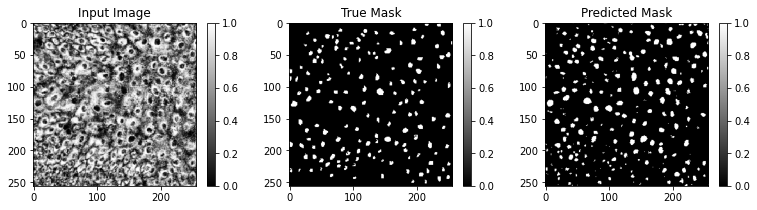

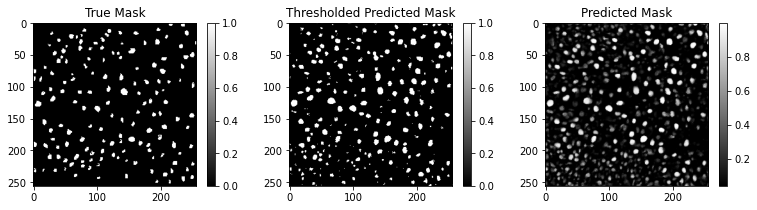

In [178]:

# new_test_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/test/1048.png'))
# new_test_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/1048.png'))

#1, 19, 30, 36, 43, 48

new_test_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/multiphoton_images/165.png'))
new_test_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/train_multiphoton_masks/masks/165.png'))



original_image2 = new_test_image/255.

# new_test_image = tf.image.rgb_to_grayscale(new_test_image, name=None)
# new_test_image = reshape(new_test_image,(256,256))
# original_image2 = new_test_image
# new_test_image = np.stack((new_test_image,)*3, axis=-1)

    
new_test_image = np.expand_dims(new_test_image, axis = 0)/255.
predict_array = m.predict(new_test_image) 
    
arr_pred = predict_array[0,:, :]
newimage = reshape(arr_pred,(256,256))

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)
pos1 = ax1.imshow(original_image2, cmap = "gray")
fig.colorbar(pos1, ax=ax1)
ax1.set_title('Input Image')
    
pos2 = ax2.imshow(new_test_mask >.5, cmap = "gray")
fig.colorbar(pos2, ax=ax2)
ax2.set_title('True Mask')
    
pos3 = ax3.imshow(newimage > .5, cmap = "gray")
fig.colorbar(pos3, ax=ax3)
ax3.set_title('Predicted Mask')
    
#print("dice coef: " + str(dice_coef(sample_mask, pred)))

pred.shape
dice_score_img(new_test_mask, newimage, newimage) 

Text(0.5, 1.0, 'Mask')

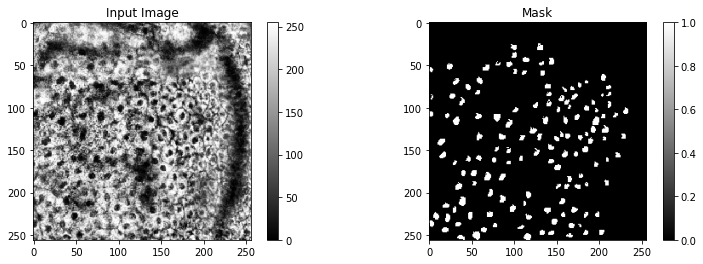

In [196]:
new_test_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/multiphoton_images/218.png'))
new_test_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/train_multiphoton_masks/masks/218.png'))

                                  
fig, (ax1, ax2) = plt.subplots(figsize=(13, 4), ncols=2)
pos1 = ax1.imshow(new_test_image, cmap = "gray")
fig.colorbar(pos1, ax=ax1)
ax1.set_title('Input Image')
    
pos2 = ax2.imshow(new_test_mask > .50, cmap = "gray")
fig.colorbar(pos2, ax=ax2)
ax2.set_title('Mask')

(1, 256, 256, 3)


Text(0.5, 1.0, 'Predicted Mask')

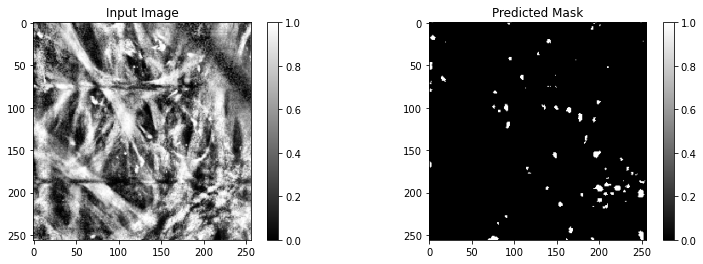

In [190]:
new_test_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/multiphoton_images/170.png'))
original_image2 = new_test_image/255.
    
new_test_image = np.expand_dims(new_test_image, axis = 0)/255.
print(new_test_image.shape)
predict_array = m.predict(new_test_image) 
    
arr_pred = predict_array[0,:, :]
newimage = reshape(arr_pred,(256,256))

fig, (ax1, ax2) = plt.subplots(figsize=(13, 4), ncols=2)
pos1 = ax1.imshow(original_image2, cmap = "gray")
fig.colorbar(pos1, ax=ax1)
ax1.set_title('Input Image')
    
pos2 = ax2.imshow(newimage > .20, cmap = "gray")
fig.colorbar(pos2, ax=ax2)
ax2.set_title('Predicted Mask')

dict_keys(['loss', 'accuracy', 'dice_coef_metric', 'val_loss', 'val_accuracy', 'val_dice_coef_metric'])


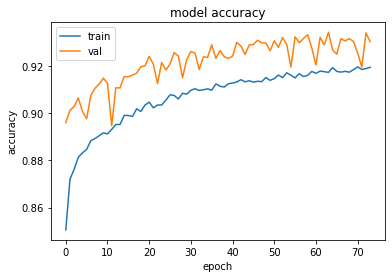

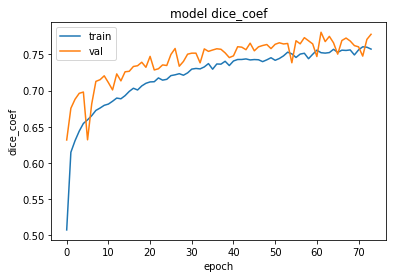

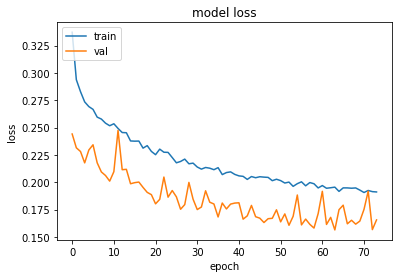

In [34]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef_metric'])
plt.plot(history.history['val_dice_coef_metric'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'dice_coef_metric', 'val_loss', 'val_accuracy', 'val_dice_coef_metric'])


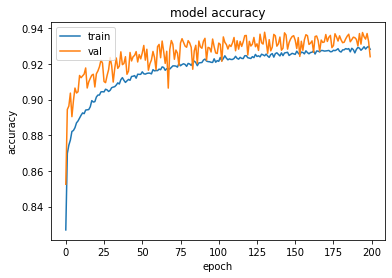

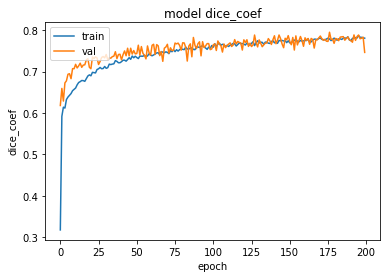

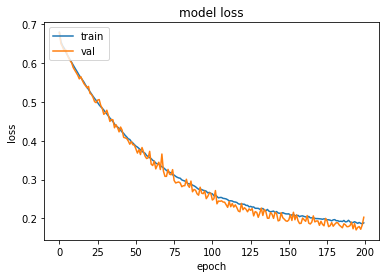

In [32]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['dice_coef_metric'])
plt.plot(history.history['val_dice_coef_metric'])
plt.title('model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
test_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/test/101.png'))
test_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/101.png'))
pred = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/epoch_checkpoint3.1/5_predict_epoch.png'))
# print(dice_coef_metric(test_mask, pred))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


dice coef: 0.5775146484375


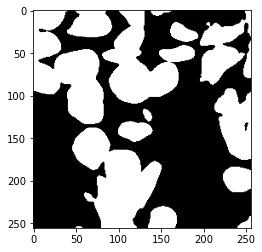

In [122]:
test_image2 = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_images/test/1043.png'))
test_mask2 = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/test_masks/test/1043.png'))

#1, 19, 30, 36, 43, 48

# train_image = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/train_images/train/10.png'))
# train_mask = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/train_masks/train/10.png'))

# image = tf.image.rgb_to_grayscale(train_image, name=None)
# newimage = reshape(image,(256,256))
# newimage = np.stack((newimage,)*3, axis=-1)


pred_mask(test_image, test_mask,9)


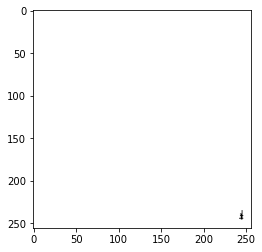

In [73]:
img = array(Image.open('/s/bach/j/under/mikylab/research/segmentation_dataset2/epoch_checkpoint3.1/0_predict_epoch.png'))
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 1)

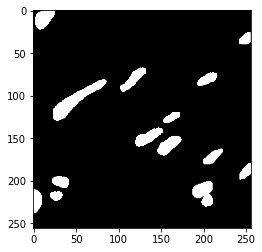

In [62]:
#plt.imshow(train_image)
plt.imshow(train_mask, cmap = 'gray', vmin = 0, vmax = 1)

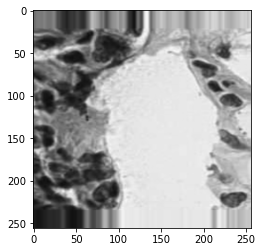

In [112]:
x= image_generator.next()
for i in range(0,1):
    image = x[i]
    #newimage = reshape(image,(256,256))
    #plt.imshow(newimage, cmap = 'gray')
    plt.imshow(image)
    plt.show()